In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model



# System libraries
from pathlib import Path
import os.path
import random

# Visualization Libraries
import matplotlib.cm as cm
import seaborn as sns
import cv2

# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

import warnings
warnings.filterwarnings('ignore')

In [4]:
dataset = "/kaggle/input/cassava-leaf-disease-classification/train"
image_dir=Path(dataset)
image_dir
image_dir = Path(dataset)
filepath = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))


In [5]:
filepath = pd.Series(filepath, name = "filepaths").astype("str")
labels = pd.Series(labels, name = "labels" )
df = pd.concat([filepath, labels], axis = 1)


In [6]:
df.head(3)

filepaths  \
0  /kaggle/input/cassava-leaf-disease-classificat...   
1  /kaggle/input/cassava-leaf-disease-classificat...   
2  /kaggle/input/cassava-leaf-disease-classificat...   

                                labels  
0  Cassava Brown Streak Disease (CBSD)  
1  Cassava Brown Streak Disease (CBSD)  
2  Cassava Brown Streak Disease (CBSD)

In [7]:
df.labels.value_counts()

labels
Cassava Mosaic Disease (CMD)           10526
Healthy                                 2061
Cassava Green Mottle (CGM)              1909
Cassava Brown Streak Disease (CBSD)     1751
Cassava Bacterial Blight (CBB)           870
Name: count, dtype: int64

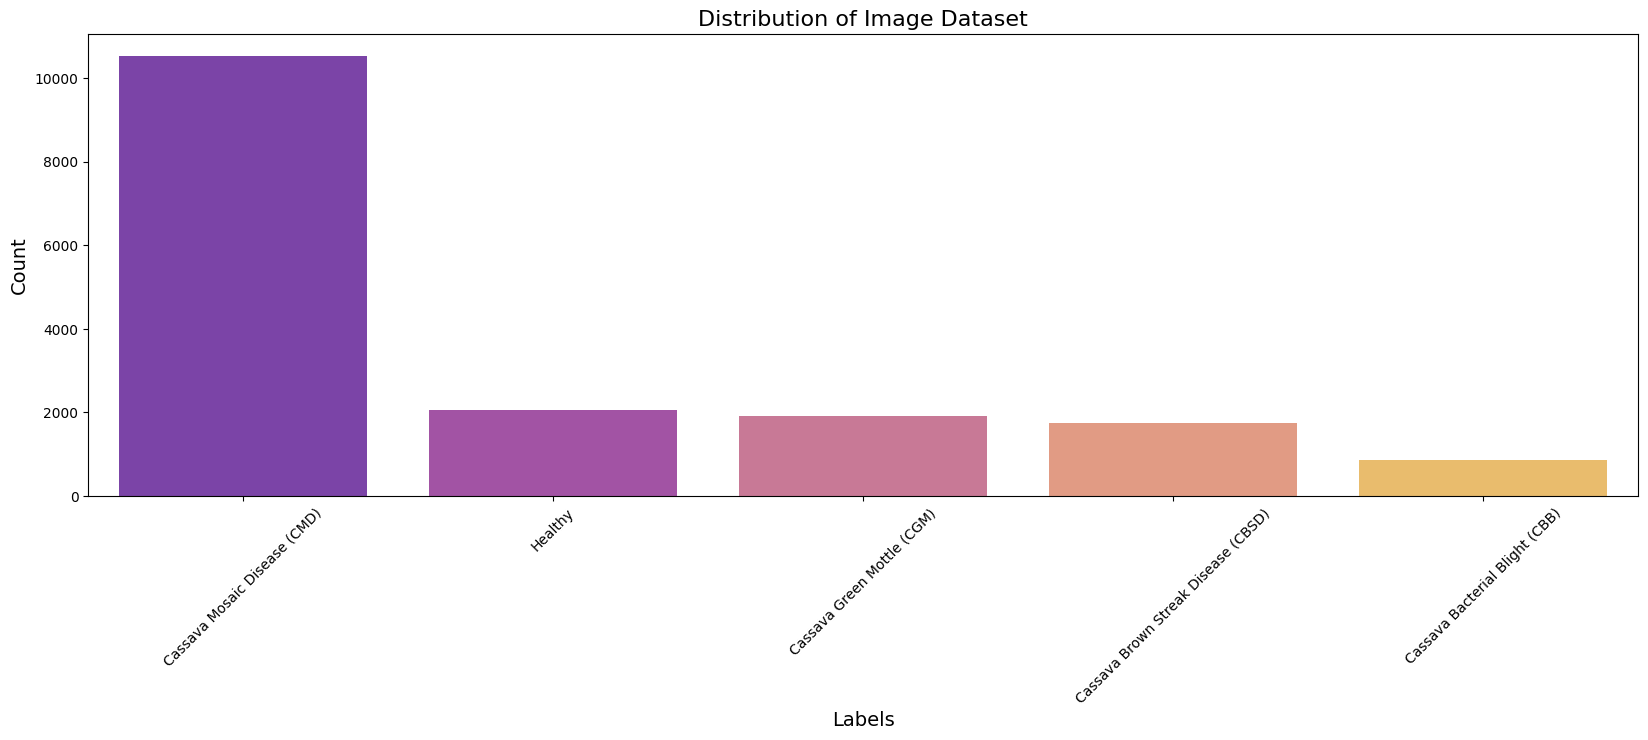

In [7]:
label_counts = df['labels'].value_counts()
plt.figure(figsize=(20, 6))
sns.barplot(x=label_counts.index, y=label_counts.values, alpha=0.8, palette='plasma')
plt.title('Distribution of Image Dataset', fontsize=16)
plt.xlabel('Labels', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.show()

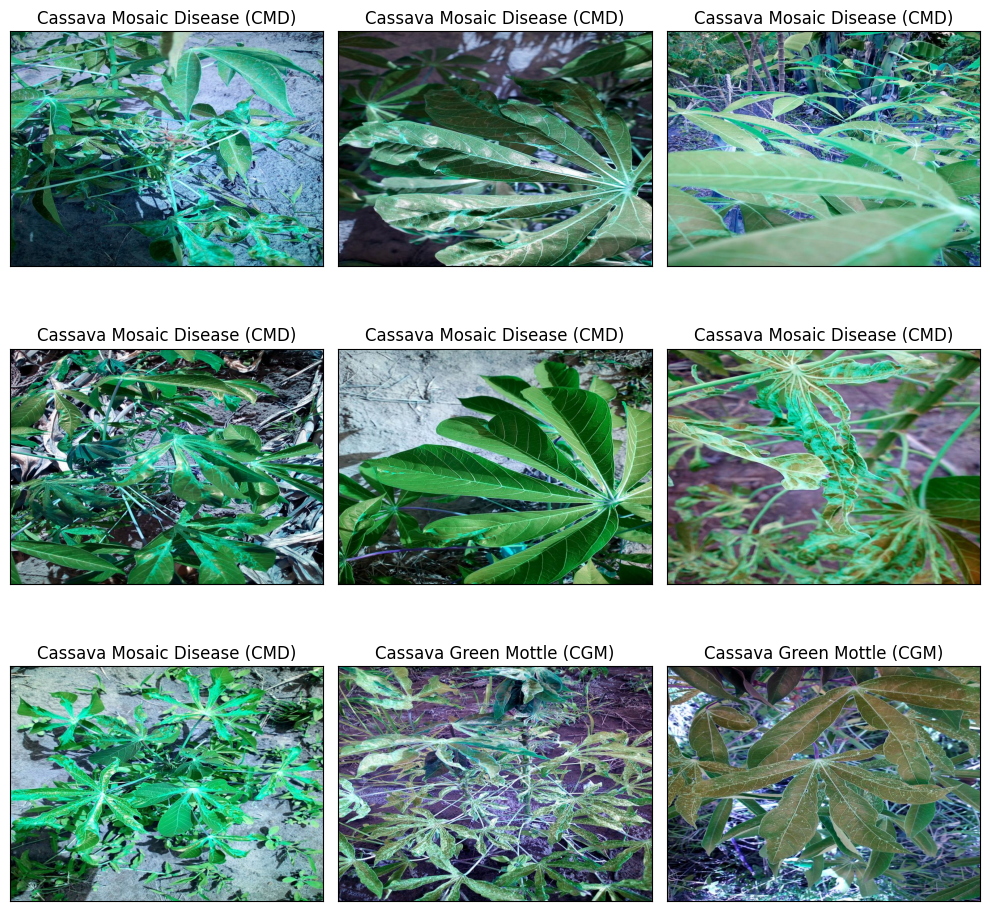

In [8]:
random_index = np.random.randint(0, len(df), 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(df.filepaths[random_index[i]]))
    ax.set_title(df.labels[random_index[i]])
plt.tight_layout()
plt.show()

In [9]:
df_class_cmd = df[df['labels'] == 'Cassava Mosaic Disease (CMD)']
df_class_hel = df[df['labels'] == 'Healthy']
df_class_cgm = df[df['labels'] == 'Cassava Green Mottle (CGM)']
df_class_cbsd = df[df['labels'] == 'Cassava Brown Streak Disease (CBSD)']
df_class_cbb = df[df['labels'] == 'Cassava Bacterial Blight (CBB)']
df_class_cmd_b = df_class_cmd.sample(2000)
df_class_hel_b = df_class_hel.sample(2000, replace=True)
df_class_cgm_b = df_class_cgm.sample(2000, replace=True)
df_class_cbsd_b = df_class_cbsd.sample(2000, replace=True)
df_class_cbb_b = df_class_cbb.sample(2000, replace=True)
df_b = pd.concat([df_class_cmd_b, df_class_hel_b,df_class_cgm_b ,df_class_cbsd_b,df_class_cbb_b], axis=0)

In [10]:
df_b.labels.value_counts()

labels
Cassava Mosaic Disease (CMD)           2000
Healthy                                2000
Cassava Green Mottle (CGM)             2000
Cassava Brown Streak Disease (CBSD)    2000
Cassava Bacterial Blight (CBB)         2000
Name: count, dtype: int64

In [11]:
train_df, val_df = train_test_split(df_b, test_size=0.2, shuffle=True, random_state=42)

In [8]:
#train_df, val_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

In [9]:
train_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

val_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

In [10]:
BATCH_SIZE = 32
TARGET_SIZE = (256, 256)
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepaths',
    y_col='labels',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = val_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepaths',
    y_col='labels',
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False,
   )

Found 13693 validated image filenames belonging to 5 classes.
Found 3424 validated image filenames belonging to 5 classes.


In [11]:
augment = tf.keras.Sequential([
    layers.Resizing(256,256),
  layers.Rescaling(1./255),
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.1),
  layers.RandomZoom(0.1),
  layers.RandomContrast(0.1),
])

In [16]:
# pretrained_model = tf.keras.applications.efficientnet.EfficientNetB0(
#     input_shape=(256, 256, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='max'
# )

# pretrained_model.trainable = False

In [17]:
# inputs = pretrained_model.input
# x = augment(inputs)

# x = Dense(128, activation='relu')(pretrained_model.output)
# x = Dropout(0.30)(x)
# x = Dense(256, activation='relu')(x)
# x = Dropout(0.30)(x)


# outputs = Dense(5, activation='softmax')(x)

# model = Model(inputs=inputs, outputs=outputs)

# model.compile(
#     optimizer=Adam(0.0001),
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

In [18]:
# history = model.fit(
#     train_images,
#     validation_data=val_images,
#     epochs=50,
#     batch_size=32,
# )

In [12]:
dataset2 = "/kaggle/input/cassava-leaf-disease-classification/test"
image_dir=Path(dataset2)
image_dir = Path(dataset2)
filepath = list(image_dir.glob(r'**/*.jpg')) + list(image_dir.glob(r'**/*.jpeg')) + list(image_dir.glob(r'**/*.JPG')) + list(image_dir.glob(r'**/*.png'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepath))
filepath = pd.Series(filepath, name = "filepaths").astype("str")
labels = pd.Series(labels, name = "labels" )
test_df = pd.concat([filepath, labels], axis = 1)

In [20]:
test_df.head(3)

filepaths  \
0  /kaggle/input/cassava-leaf-disease-classificat...   
1  /kaggle/input/cassava-leaf-disease-classificat...   
2  /kaggle/input/cassava-leaf-disease-classificat...   

                                labels  
0  Cassava Brown Streak Disease (CBSD)  
1  Cassava Brown Streak Disease (CBSD)  
2  Cassava Brown Streak Disease (CBSD)

In [13]:
test_generator = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepaths',
    y_col='labels',
    #target_size=TARGET_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 4280 validated image filenames belonging to 5 classes.


In [14]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
# from tensorflow.keras.models import Model
input_shape = (256, 256, 3)

inputs = Input(shape=input_shape)

x = augment(inputs)
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(64, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)
x = Conv2D(128, (3, 3), activation='relu')(x)
x = MaxPooling2D((2, 2))(x)


x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.35)(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.30)(x)
outputs = Dense(5, activation='softmax')(x)  


model = Model(inputs, outputs)

In [51]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 254, 254, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 127, 127, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 125, 125, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_20 (MaxPooling2D) │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 28, 28, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_23 (Conv2D)              │ (None, 12, 12, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_24 (Conv2D)              │ (None, 4, 4, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_24 (MaxPooling2D) │ (None, 2, 2, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 479,557 (1.83 MB)

 Trainable params: 479,557 (1.83 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer=Adam(0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [16]:
history =model.fit(train_images,  epochs=50, validation_data=val_images)

Epoch 1/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 214s 476ms/step - accuracy: 0.6169 - loss: 1.2315 - val_accuracy: 0.6230 - val_loss: 1.1247
Epoch 2/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 100s 229ms/step - accuracy: 0.6116 - loss: 1.1370 - val_accuracy: 0.6349 - val_loss: 1.0943
Epoch 3/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 110s 255ms/step - accuracy: 0.6288 - loss: 1.0361 - val_accuracy: 0.6452 - val_loss: 1.0290
Epoch 4/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 109s 250ms/step - accuracy: 0.6404 - loss: 0.9982 - val_accuracy: 0.5958 - val_loss: 1.1199
Epoch 5/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 93s 215ms/step - accuracy: 0.6411 - loss: 0.9569 - val_accuracy: 0.6364 - val_loss: 1.0013
Epoch 6/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 79s 181ms/step - accuracy: 0.6487 - loss: 0.9513 - val_accuracy: 0.6104 - val_loss: 1.0485
Epoch 7/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 85s 197ms/step - accuracy: 0.6561 - loss: 0.9391 - val_accuracy: 0.6516 - val_loss: 0.9620
Epoch 8/50
428/428 ━━━━━━━━━━━━━━━━━━━━ 95s 218ms/step - accuracy: 0.6592 - los

In [55]:
results = model.evaluate(val_images, verbose=0)

print("    Val Loss: {:.5f}".format(results[0]))
print("Val Accuracy: {:.2f}%".format(results[1] * 100))

    Val Loss: 1.06270
Val Accuracy: 59.15%


In [56]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 1.12340
Test Accuracy: 54.81%


In [17]:
results = model.evaluate(val_images, verbose=0)

print("Val Loss Unbalanced data: {:.5f}".format(results[0]))
print("Val Accuracy Unbalanced data: {:.2f}%".format(results[1] * 100))

Val Loss Unbalanced data: 0.90991
Val Accuracy Unbalanced data: 65.30%


In [19]:
results = model.evaluate(test_images, verbose=0)

print("Test Loss Unbalanced data: {:.5f}".format(results[0]))
print("Test Accuracy Unbalanced data: {:.2f}%".format(results[1] *100))

Test Loss Unbalanced data: 0.93445
Test Accuracy Unbalanced data: 64.18%


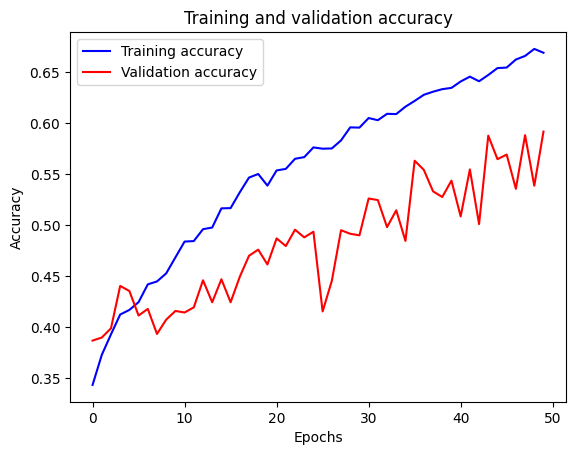

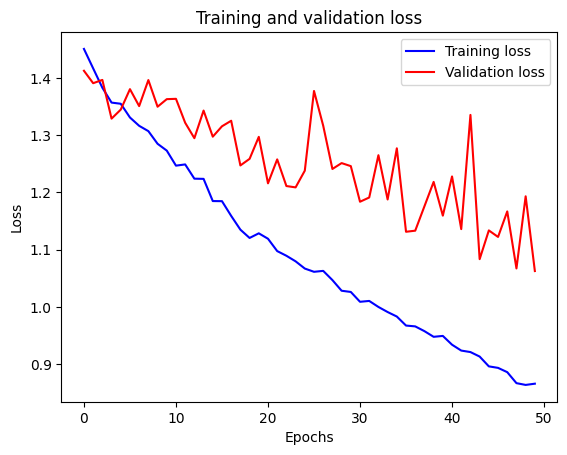

In [58]:
#by balanced data
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

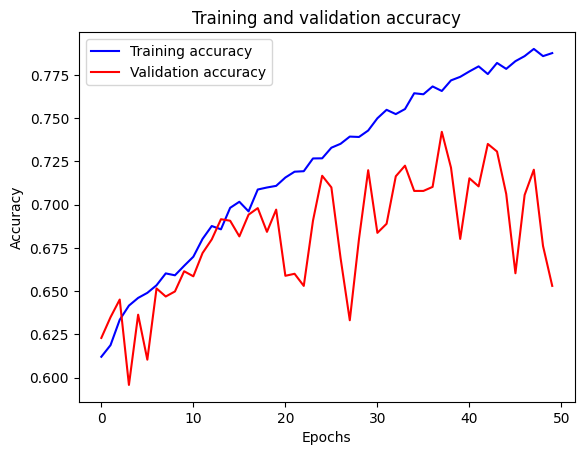

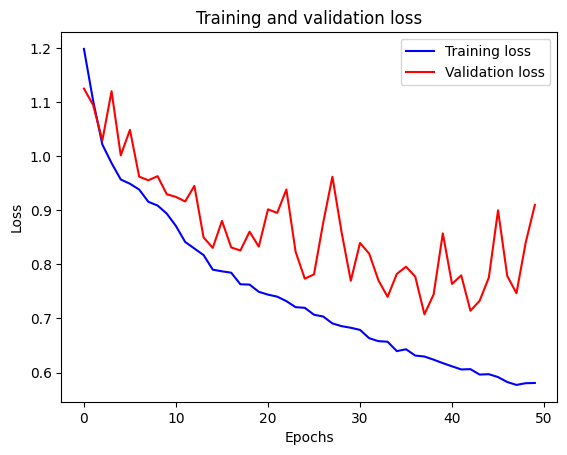

In [20]:
#by un_balanced data
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(accuracy))
plt.plot(epochs, accuracy, 'b', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'r', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [21]:
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred = [labels[k] for k in pred]

134/134 ━━━━━━━━━━━━━━━━━━━━ 51s 379ms/step


In [60]:
#by balanced data
y_test = list(test_df.labels)
print(classification_report(y_test, pred))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.37      0.45      0.41       217
Cassava Brown Streak Disease (CBSD)       0.41      0.54      0.47       438
         Cassava Green Mottle (CGM)       0.27      0.53      0.36       477
       Cassava Mosaic Disease (CMD)       0.94      0.56      0.70      2632
                            Healthy       0.30      0.55      0.39       516

                           accuracy                           0.55      4280
                          macro avg       0.46      0.53      0.46      4280
                       weighted avg       0.71      0.55      0.59      4280



In [22]:
#by unbalanced data
y_test = list(test_df.labels)
print(classification_report(y_test, pred))

                                     precision    recall  f1-score   support

     Cassava Bacterial Blight (CBB)       0.40      0.39      0.39       217
Cassava Brown Streak Disease (CBSD)       0.76      0.30      0.43       438
         Cassava Green Mottle (CGM)       0.40      0.44      0.42       477
       Cassava Mosaic Disease (CMD)       0.92      0.73      0.82      2632
                            Healthy       0.30      0.75      0.43       516

                           accuracy                           0.64      4280
                          macro avg       0.56      0.52      0.50      4280
                       weighted avg       0.75      0.64      0.67      4280



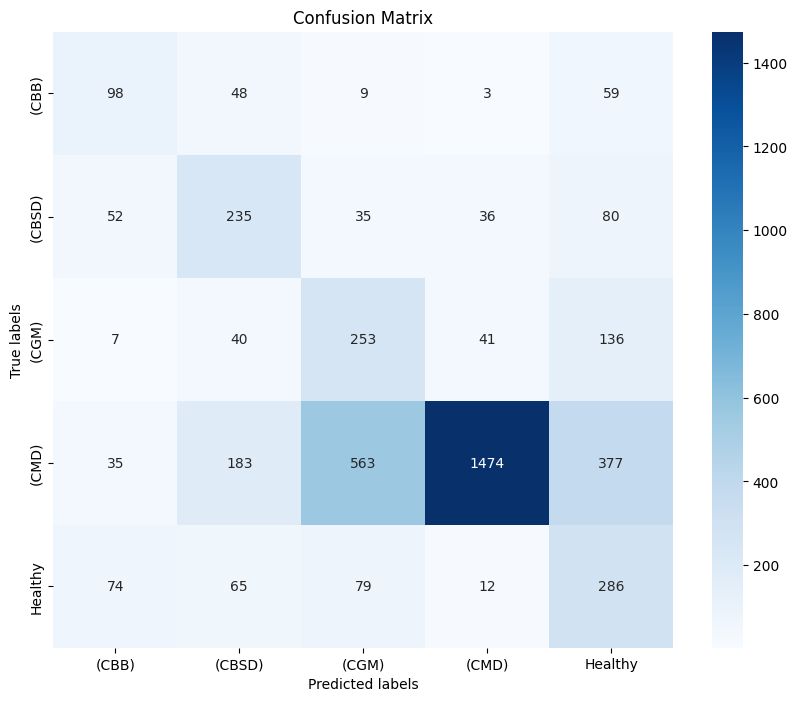

In [61]:
#by balanced data
conf_matrix = confusion_matrix(y_test, pred)
class_names = ['(CBB)','(CBSD)','(CGM)','(CMD)','Healthy']


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


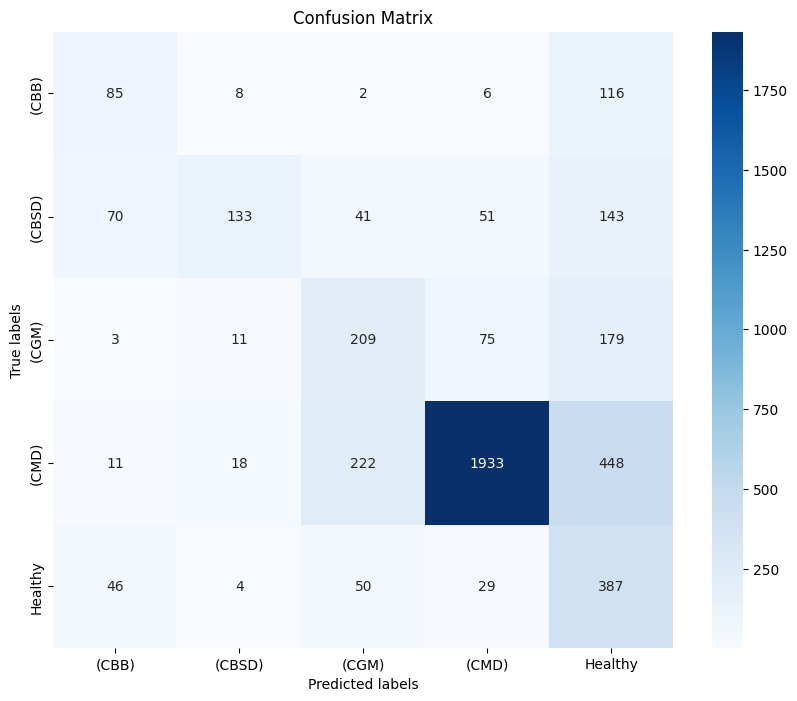

In [25]:
#by un_balanced data
conf_matrix = confusion_matrix(y_test, pred)
class_names = ['(CBB)','(CBSD)','(CGM)','(CMD)','Healthy']


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


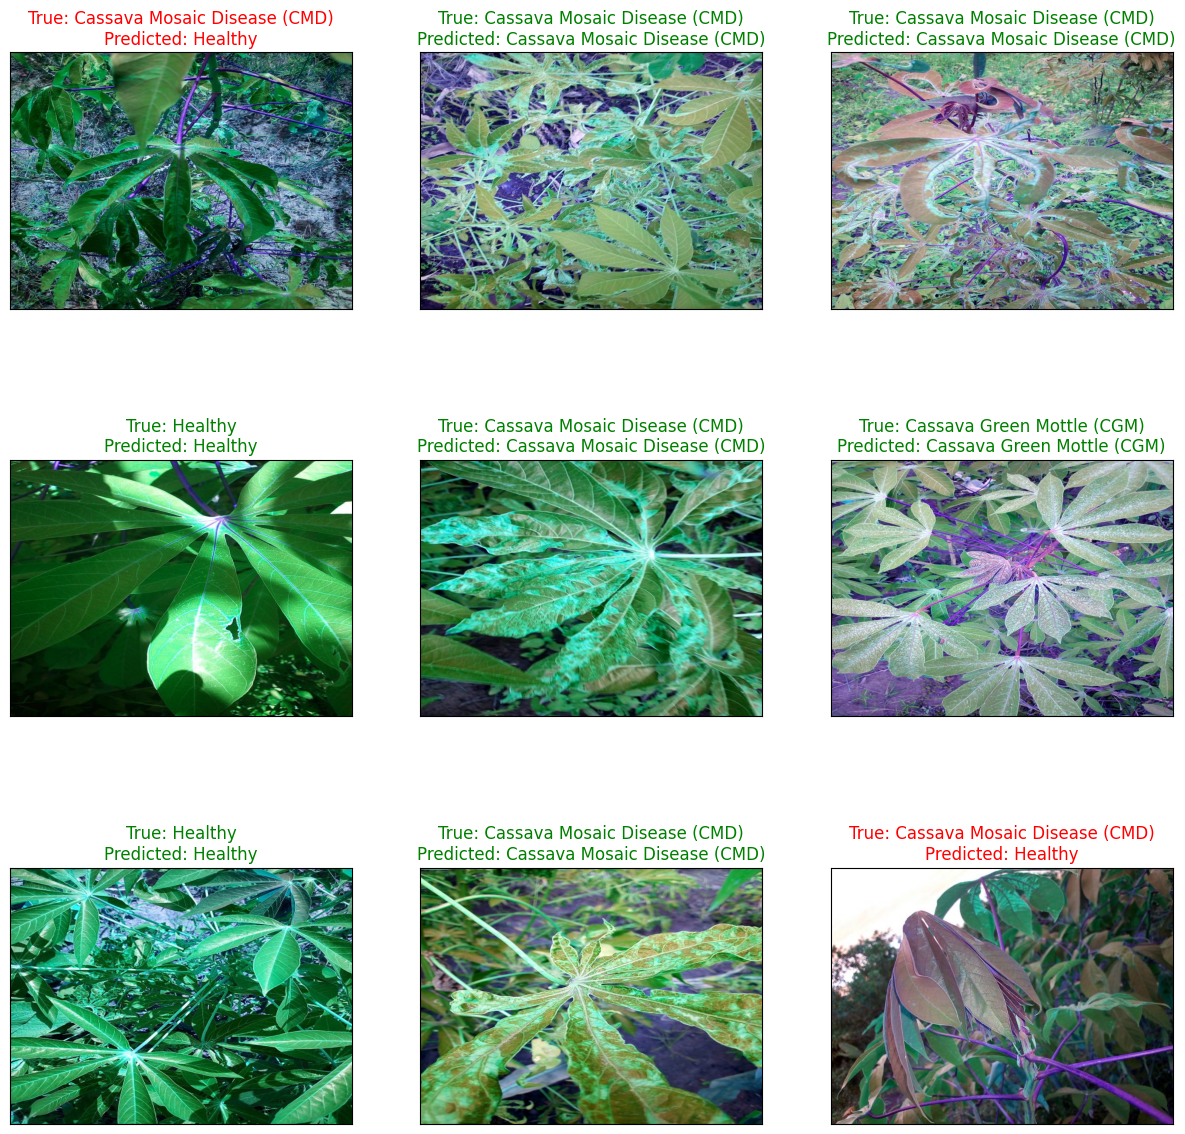

<Figure size 640x480 with 0 Axes>

In [63]:
#by balanced data
random_index = np.random.randint(0, len(test_df) - 1, 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(test_df.filepaths.iloc[random_index[i]]))
    if test_df.labels.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.labels.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()

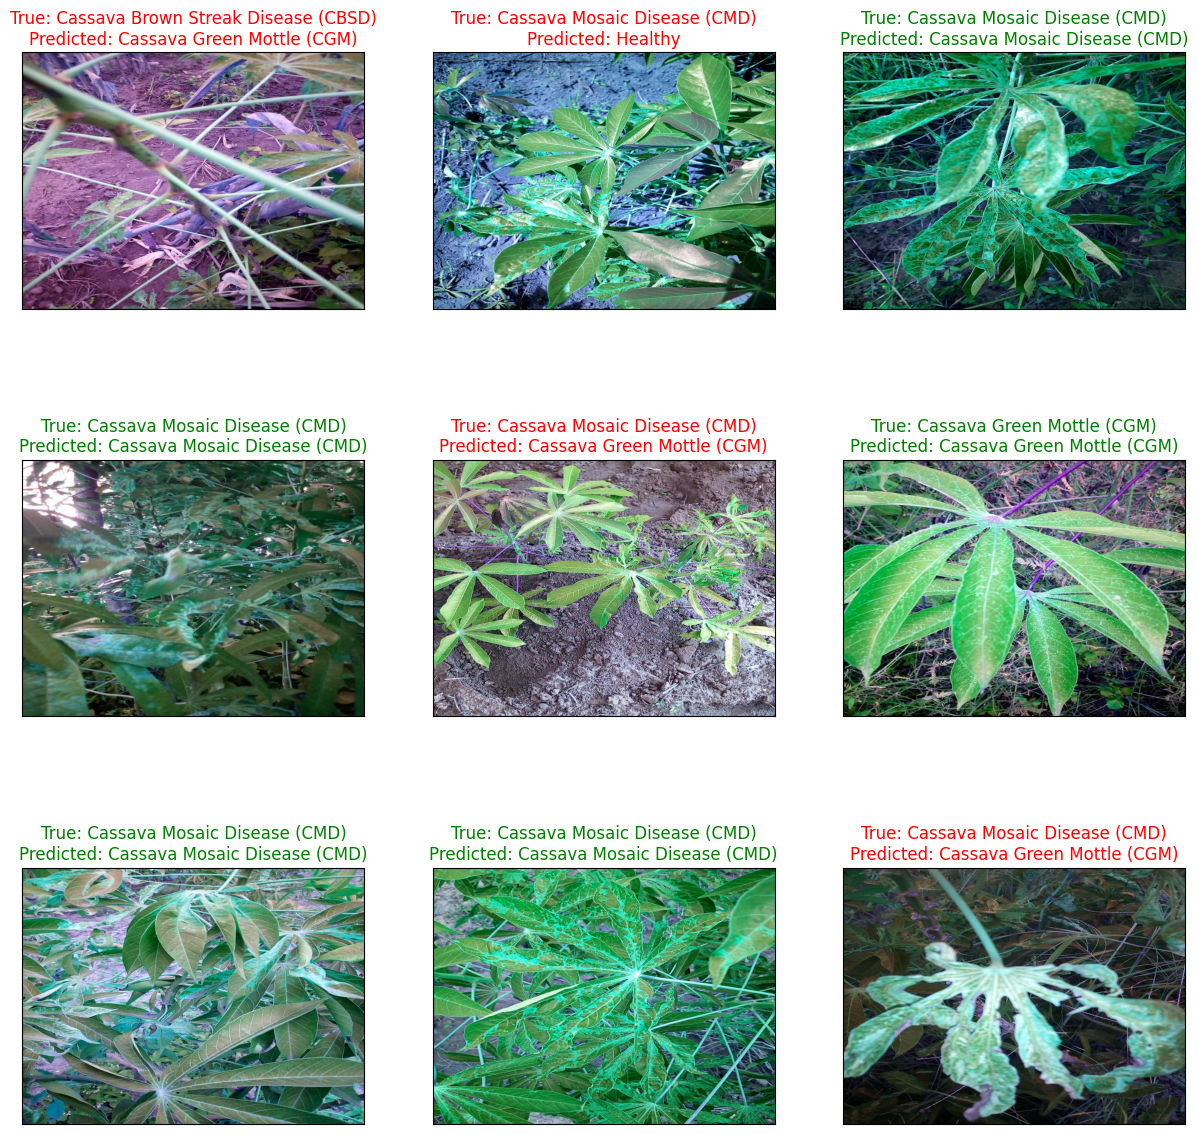

<Figure size 640x480 with 0 Axes>

In [28]:
#by un_balanced data
random_index = np.random.randint(0, len(test_df) - 1, 9)
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(cv2.imread(test_df.filepaths.iloc[random_index[i]]))
    if test_df.labels.iloc[random_index[i]] == pred[random_index[i]]:
        color = "green"
    else:
        color = "red"
    ax.set_title(f"True: {test_df.labels.iloc[random_index[i]]}\nPredicted: {pred[random_index[i]]}", color=color)
plt.show()
plt.tight_layout()
